In [13]:
# Загружаем необходимые библиотеки
import torch
import pandas as pd
import numpy as np
import lightgbm as lgb
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score
from tqdm.auto import tqdm
import warnings

warnings.filterwarnings('ignore')
tqdm.pandas()

In [14]:
# Проверяем, что gpu активно
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Используется: {device}")

Используется: cuda


In [15]:
# ЧАСТЬ 1: ЗАГРУЗКА И ГЕНЕРАЦИЯ ВСЕХ ПРИЗНАКОВ

print("ЧАСТЬ 1: ЗАГРУЗКА И ГЕНЕРАЦИЯ ВСЕХ ПРИЗНАКОВ")

# Загружаем и подготавливаем данные 
df = pd.read_csv('clean_train_final.csv')

# Генерируем текстовые признаки 
print("Генерируем текстовые признаки...")
df['name_char_len'] = df['name'].str.len()
df['type_char_len'] = df['type'].str.len()
df['name_word_count'] = df['name'].str.split().str.len()
df['type_word_count'] = df['type'].str.split().str.len()
df['char_len_ratio'] = df['name_char_len'] / (df['type_char_len'] + 1)
df['word_count_ratio'] = df['name_word_count'] / (df['type_word_count'] + 1)
df['name_has_digit'] = df['name'].str.contains(r'\d').astype(int)

# Генерируем эмбеддинги, если их еще нет и косинусную схожесть
print("Генерируем эмбеддинги (это может занять время)...")
model_emb = SentenceTransformer("ai-forever/sbert_large_nlu_ru")

# Для ускорения можно сохранить и загружать готовые эмбеддинги
try:
    name_embeddings = np.load('final_name.npy')
    type_embeddings = np.load('final_type.npy')
    print("Загружены готовые эмбеддинги.")
except FileNotFoundError:
    print("Генерируем эмбеддинги для 'name'...")
    name_embeddings = model_emb.encode(df['name'].astype(str).tolist(), show_progress_bar=True)
    np.save('embeddings_name_full.npy', name_embeddings)
    print("Генерируем эмбеддинги для 'type'...")
    type_embeddings = model_emb.encode(df['type'].astype(str).tolist(), show_progress_bar=True)
    np.save('embeddings_type_full.npy', type_embeddings)

print("Рассчитываем косинусную схожесть...")
cos_sim = np.einsum('ij,ij->i', name_embeddings, type_embeddings) / (
    np.linalg.norm(name_embeddings, axis=1) * np.linalg.norm(type_embeddings, axis=1)
)
df['cosine_similarity'] = cos_sim


ЧАСТЬ 1: ЗАГРУЗКА И ГЕНЕРАЦИЯ ВСЕХ ПРИЗНАКОВ
Генерируем текстовые признаки...
Генерируем эмбеддинги (это может занять время)...
Загружены готовые эмбеддинги.
Рассчитываем косинусную схожесть...


Загружаем предварительно очищенный датасет. На этом этапе предполагается, что пропуски уже заполнены, а дубликаты удалены.

1. Генерация простых текстовых признаков. Создаем набор "статистических" признаков, описывающих структуру текста.

- Длина названия и типа в символах

- Количество слов в названии и типе

- Отношение длин (помогает понять, насколько название больше типа)

- Флаг наличия цифр в названии (важный сигнал для модели)

2. Генерация семантических признаков (эмбеддинги) 

Загружаем предобученную трансформерную модель для преобразования текста в векторы (эмбеддинги).Модель 'ai-forever/sbert_large_nlu_ru' хорошо обучена на русском языке.

Для ускорения последующих запусков, пытаемся загрузить уже сгенерированные эмбеддинги.
Если файлы не найдены, генерируем их и сохраняем на диск.

3. Расчет косинусной схожести. Это один из самых мощных признаков. Он измеряет семантическую (смысловую) близость между названием и типом товара, основываясь на их эмбеддингах. Добавляем результат как новую колонку в датафрейм


In [16]:
# Проводим базовую оценку до обучения, чтобы было с чем сравнивать качество

from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, roc_auc_score

print("БАЗОВАЯ ОЦЕНКА (ДО ОБУЧЕНИЯ)")

# Определяем признаки (любая колонка, т.к. модель их не использует) и цель
X_dummy = df[['name']] 
y_dummy = df['target']

# Создаем модель, которая всегда предсказывает самый частый класс
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_dummy, y_dummy)
y_pred_dummy = dummy_clf.predict(X_dummy)
y_proba_dummy = dummy_clf.predict_proba(X_dummy)[:, 1]

# Формируем отчет по качеству для базовой модели
print("\nОтчет по качеству для базовой модели")
print(classification_report(y_dummy, y_pred_dummy, target_names=['Type Not Match (0)', 'Type Match (1)']))

# ROC-AUC для базовой модели
auc_dummy = roc_auc_score(y_dummy, y_proba_dummy)
print(f"ROC-AUC для базовой модели: {auc_dummy:.4f}")


БАЗОВАЯ ОЦЕНКА (ДО ОБУЧЕНИЯ)

Отчет по качеству для базовой модели
                    precision    recall  f1-score   support

Type Not Match (0)       0.53      1.00      0.69    377910
    Type Match (1)       0.00      0.00      0.00    337373

          accuracy                           0.53    715283
         macro avg       0.26      0.50      0.35    715283
      weighted avg       0.28      0.53      0.37    715283

ROC-AUC для базовой модели: 0.5000


#### БАЗОВАЯ ОЦЕНКА (ДО ОБУЧЕНИЯ)
Этот анализ показывает отправную точку — качество модели, которая просто угадывает, не используя никакие признаки.

**Логика модели** DummyClassifier(strategy="most_frequent") примерно такая: посмотрел на наши данные, увидел, что класс 1 ("Type Match") встречается чуть чаще, и решил всегда предсказывать 1.

**Метрики для класса "0"** равны нулю: Так как модель никогда не предсказывает 0, она не может правильно определить ни одного примера этого класса. Поэтому precision, recall и f1-score для него равны нулю.

**Accuracy** примерно 50%: Точность — это доля правильных ответов. Поскольку модель всегда говорит 1, она права в 50.3% случаев (когда реальная метка действительно 1).

**ROC-AUC** = 0.5000: Хуже показателя быть не может. Такой показатель у модели, которая не имеет никакой предсказательной силы и работает не лучше, чем случайное угадывание.

**Главный вывод**: Любая осмысленная модель, которую мы создадим, должна показать результаты значительно лучше этих. Это эталон, с которым мы будем сравнивать свой успех.

А наши критерии успеха:
- ROC-AUC > 0.85 (чем выше, тем лучше ранжируемость).
- Precision@5 > 0.7 (чтобы в топ-5 рекомендациях было ≥70% правильных типов).
- Интерпретируемость (можно объяснить, почему модель рекомендует тот или иной тип).


In [17]:
# ЧАСТЬ 2: ПОДГОТОВКА К ОБУЧЕНИЮ

print("\nЧАСТЬ 2: ПОДГОТОВКА К ОБУЧЕНИЮ")

# Формируем набор признаков
text_features = [
    'name_char_len', 'type_char_len', 'name_word_count', 'type_word_count',
    'char_len_ratio', 'word_count_ratio', 'name_has_digit', 'cosine_similarity'
]

# Создаем временный датафрейм X со всеми признаками
X = pd.concat([
    df[text_features],
    pd.DataFrame(name_embeddings, columns=[f'name_emb_{i}' for i in range(name_embeddings.shape[1])]),
    pd.DataFrame(type_embeddings, columns=[f'type_emb_{i}' for i in range(type_embeddings.shape[1])]),
    df[['category_l2', 'category_l4', 'is_markup']] # Добавляем категории для кодирования
], axis=1)

# Кодируем категориальные признаков в числа
# Применяем LabelEncoder к строковым колонкам
le_l2 = LabelEncoder()
le_l4 = LabelEncoder()
X['category_l2_enc'] = le_l2.fit_transform(X['category_l2'])
X['category_l4_enc'] = le_l4.fit_transform(X['category_l4'])

# Удаляем исходные строковые колонки
X = X.drop(columns=['category_l2', 'category_l4'])

y = df['target']
print(f"Финальный набор признаков готов. Количество признаков: {X.shape[1]}")



ЧАСТЬ 2: ПОДГОТОВКА К ОБУЧЕНИЮ
Финальный набор признаков готов. Количество признаков: 1547


#### Сбор и подготовка итогового набора данных для обучения модели
Мы создаем финальную таблицу X (признаки) и вектор y (цель), которые будут использоваться для обучения. Процесс состоит из трех основных шагов: 
- Объединение всех признаков: простых текстовых, категориальных, эмбеддингов названий и типов  

- Кодирование категорий: так как модели машинного обучения не умеют работать с текстом напрямую, приходится использовать LabelEncoder для преобразования текстовых категорий (например, "Дом и сад", "Одежда") в числовые коды (0, 1, 2 и т.д.).

- Очистка: После кодирования исходные текстовые колонки категорий (category_l2, category_l4) удаляются, чтобы не дублировать информацию.

В результате мы получили готовую к обучению матрицу X, где все данные представлены в числовом виде.


In [19]:
# ЧАСТЬ 3: ОБУЧЕНИЕ С ОЦЕНКОЙ КАЧЕСТВА И СОХРАНЕНИЕ МОДЕЛИ

from joblib import dump

# КРОСС-ВАЛИДАЦИЯ ДЛЯ ЧЕСТНОЙ ОЦЕНКИ КАЧЕСТВА
print("\nКросс-валидация для оценки модели")

N_SPLITS = 5
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)
oof_preds = np.zeros(len(df))

for fold, (train_idx, val_idx) in enumerate(tqdm(skf.split(X, y), total=N_SPLITS, desc="Обучение по фолдам")):
    print(f"\nФОЛД {fold+1}/{N_SPLITS} ")
    X_train, X_val = X.iloc[train_idx].copy(), X.iloc[val_idx].copy()
    y_train, y_val = y.iloc[train_idx].copy(), y.iloc[val_idx].copy()

    # Безопасный Target Encoding
    global_mean = y_train.mean()
    map_l2 = y_train.groupby(X_train['category_l2_enc']).mean()
    X_train['te_l2'] = X_train['category_l2_enc'].map(map_l2).fillna(global_mean)
    X_val['te_l2'] = X_val['category_l2_enc'].map(map_l2).fillna(global_mean)
    
    map_l4 = y_train.groupby(X_train['category_l4_enc']).mean()
    X_train['te_l4'] = X_train['category_l4_enc'].map(map_l4).fillna(global_mean)
    X_val['te_l4'] = X_val['category_l4_enc'].map(map_l4).fillna(global_mean)
    
    # Обучаем модель ТОЛЬКО НА X_train
    model_fold = lgb.LGBMClassifier(
        objective='binary', 
        metric='auc', 
        random_state=42, 
        n_estimators=1000,
    )
    
    cat_feature_names = ['category_l2_enc', 'category_l4_enc', 'is_markup']
    
    model_fold.fit(X_train, y_train,
                   eval_set=[(X_val, y_val)],
                   eval_metric='auc',
                   categorical_feature=cat_feature_names,
                   callbacks=[lgb.early_stopping(50, verbose=False)]) # verbose=False, чтобы не засорять вывод
    
    # Оцениваем качество на X_val
    val_preds_proba = model_fold.predict_proba(X_val)[:, 1]
    oof_preds[val_idx] = val_preds_proba
    
# Выводим итоговую честную оценку
final_auc = roc_auc_score(y, oof_preds)

print(f"Кросс-валидация завершена. Итоговый ЧЕСТНЫЙ ROC-AUC: {final_auc:.4f}")




Кросс-валидация для оценки модели


Обучение по фолдам:   0%|          | 0/5 [00:00<?, ?it/s]


ФОЛД 1/5 
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 269898, number of negative: 302328
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.305690 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 395195
[LightGBM] [Info] Number of data points in the train set: 572226, number of used features: 1549
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.471663 -> initscore=-0.113468
[LightGBM] [Info] Start training from score -0.113468


Обучение по фолдам:  20%|██        | 1/5 [06:44<26:59, 404.91s/it]


ФОЛД 2/5 
[LightGBM] [Info] Number of positive: 269898, number of negative: 302328
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.346725 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 395174
[LightGBM] [Info] Number of data points in the train set: 572226, number of used features: 1549
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.471663 -> initscore=-0.113468
[LightGBM] [Info] Start training from score -0.113468


Обучение по фолдам:  40%|████      | 2/5 [13:35<20:24, 408.04s/it]


ФОЛД 3/5 
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 269898, number of negative: 302328
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.864507 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 395169
[LightGBM] [Info] Number of data points in the train set: 572226, number of used features: 1549
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.471663 -> initscore=-0.113468
[LightGBM] [Info] Start training from score -0.113468


Обучение по фолдам:  60%|██████    | 3/5 [20:56<14:06, 423.37s/it]


ФОЛД 4/5 
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 269899, number of negative: 302328
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.776031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 395171
[LightGBM] [Info] Number of data points in the train set: 572227, number of used features: 1549
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.471664 -> initscore=-0.113465
[LightGBM] [Info] Start training from score -0.113465


Обучение по фолдам:  80%|████████  | 4/5 [28:18<07:10, 430.56s/it]


ФОЛД 5/5 
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 269899, number of negative: 302328
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.865698 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 395180
[LightGBM] [Info] Number of data points in the train set: 572227, number of used features: 1549
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.471664 -> initscore=-0.113465
[LightGBM] [Info] Start training from score -0.113465


Обучение по фолдам: 100%|██████████| 5/5 [35:38<00:00, 427.80s/it]

Кросс-валидация завершена. Итоговый ЧЕСТНЫЙ ROC-AUC: 0.9752


### Выводы по результатам кросс-валидации

Процесс обучения финальной модели с использованием 5-фолдовой кросс-валидации прошел успешно и продемонстрировал высокую производительность и стабильность.

* **Надежная оценка:** Использование кросс-валидации на 5 фолдах (`5-fold Cross-Validation`) позволило получить честную и робастную оценку качества модели, исключающую случайные успехи.

* **Корректная работа с данными:** Информационные предупреждения `[Warning] Categorical features with more bins...` не являются ошибками. Они подтверждают, что модель `LightGBM` корректно распознала категориальные признаки с большим количеством уникальных значений (такие как `category_l4_enc`) и успешно обработала их с помощью своих внутренних эффективных алгоритмов.

* **Высокое качество:** Итоговый **`ROC-AUC`** на out-of-fold предсказаниях составил **0.9752**. Это показатель экспертного уровня, который говорит о превосходной способности модели отличать правильные пары "название-тип" от неправильных и эффективно их ранжировать.

> **Итог:** Модель успешно обучена, ее высокое качество подтверждено надежным методом оценки. Она готова к решению поставленной бизнес-задачи.

In [25]:
# ИТОГОВАЯ ОЦЕНКА ОБУЧЕННОЙ МОДЕЛИ (СРАВНЕНИЕ С BASELINE)

print("\nИТОГОВАЯ ОЦЕНКА ОБУЧЕННОЙ МОДЕЛИ")

# 1. Преобразуем вероятности в бинарные предсказания (0 или 1)
# Используем стандартный порог 0.5
oof_preds_binary = (oof_preds > 0.5).astype(int)

# 2. Формируем отчет по качеству для финальной модели
print("\nОтчет по качеству для финальной модели")
print(classification_report(y, oof_preds_binary, target_names=['Type Not Match (0)', 'Type Match (1)']))

# 3. ROC-AUC для финальной модели
final_auc = roc_auc_score(y, oof_preds)
print(f"Итоговый ROC-AUC для финальной модели: {final_auc:.4f}")



ИТОГОВАЯ ОЦЕНКА ОБУЧЕННОЙ МОДЕЛИ

Отчет по качеству для финальной модели
                    precision    recall  f1-score   support

Type Not Match (0)       0.91      0.94      0.92    377910
    Type Match (1)       0.93      0.89      0.91    337373

          accuracy                           0.92    715283
         macro avg       0.92      0.92      0.92    715283
      weighted avg       0.92      0.92      0.92    715283

Итоговый ROC-AUC для финальной модели: 0.9752


#### Итоговые выводы по модели
1. **Высокая предсказательная сила**: Итоговый ROC-AUC 0.9752 — это прекрасный показатель модели, который говорит о том, что система почти идеально ранжирует типы, помещая правильные варианты значительно выше неправильных. Критерий ROC-AUC > 0.85 перевыполнен с огромным запасом.

2. **Отличный баланс точности и полноты**: Метрики precision, recall и f1-score стабильно высоки (0.91-0.94) для обоих классов. Это означает, что модель:

- Очень точна: Когда она говорит, что тип подходит (precision для класса 1 = 0.93), она права в 93% случаев. Это гарантирует высокое качество рекомендаций для продавца.

- Хорошо находит ошибки: Модель обнаруживает 94% всех неверно указанных типов (recall для класса 0 = 0.94), что делает её отличным инструментом для автоматической модерации.

3. **Высокая общая точность**: Accuracy 0.92 означает, что при использовании стандартного порога 0.5, модель принимает верное решение в 92% случаев.

In [20]:
# ОБУЧЕНИЕ ФИНАЛЬНОЙ МОДЕЛИ НА ВСЕХ ДАННЫХ ДЛЯ СОХРАНЕНИЯ
print("\nОбучение финальной модели на 100% данных для передачи")

# Готовим Target Encoding на всех данных
map_l2_full = y.groupby(X['category_l2_enc']).mean()
X['te_l2'] = X['category_l2_enc'].map(map_l2_full)
map_l4_full = y.groupby(X['category_l4_enc']).mean()
X['te_l4'] = X['category_l4_enc'].map(map_l4_full)

final_model_to_save = lgb.LGBMClassifier(
    objective='binary', 
    metric='auc', 
    random_state=42, 
    n_estimators=1000, 
)

final_model_to_save.fit(X, y, categorical_feature=cat_feature_names)
print("Финальная модель обучена.")

# Собираем артефакты
artifacts = {
    'model': final_model_to_save,
    'le_l2': le_l2,
    'le_l4': le_l4,
    'target_encoding_maps': {
        'map_l2': map_l2_full,
        'map_l4': map_l4_full,
        'global_mean': y.mean()
    },
    'feature_order': final_model_to_save.feature_name_
}

dump(artifacts, 'final_model_with_artifacts.joblib')
print("\nГотово! Файл 'final_model_with_artifacts.joblib' создан и готов для передачи.")


Обучение финальной модели на 100% данных для передачи
[LightGBM] [Info] Number of positive: 337373, number of negative: 377910
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.658814 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 395192
[LightGBM] [Info] Number of data points in the train set: 715283, number of used features: 1549
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.471664 -> initscore=-0.113467
[LightGBM] [Info] Start training from score -0.113467
Финальная модель обучена.

Готово! Файл 'final_model_with_artifacts.joblib' создан и готов для передачи.



ЧАСТЬ 4: ГЛУБОКИЙ АНАЛИЗ РЕЗУЛЬТАТОВ

1. Обучаем финальную модель для анализа важности признаков...
[LightGBM] [Info] Number of positive: 337373, number of negative: 377910
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.527020 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 395192
[LightGBM] [Info] Number of data points in the train set: 715283, number of used features: 1549
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.471664 -> initscore=-0.113467
[LightGBM] [Info] Start training from score -0.113467


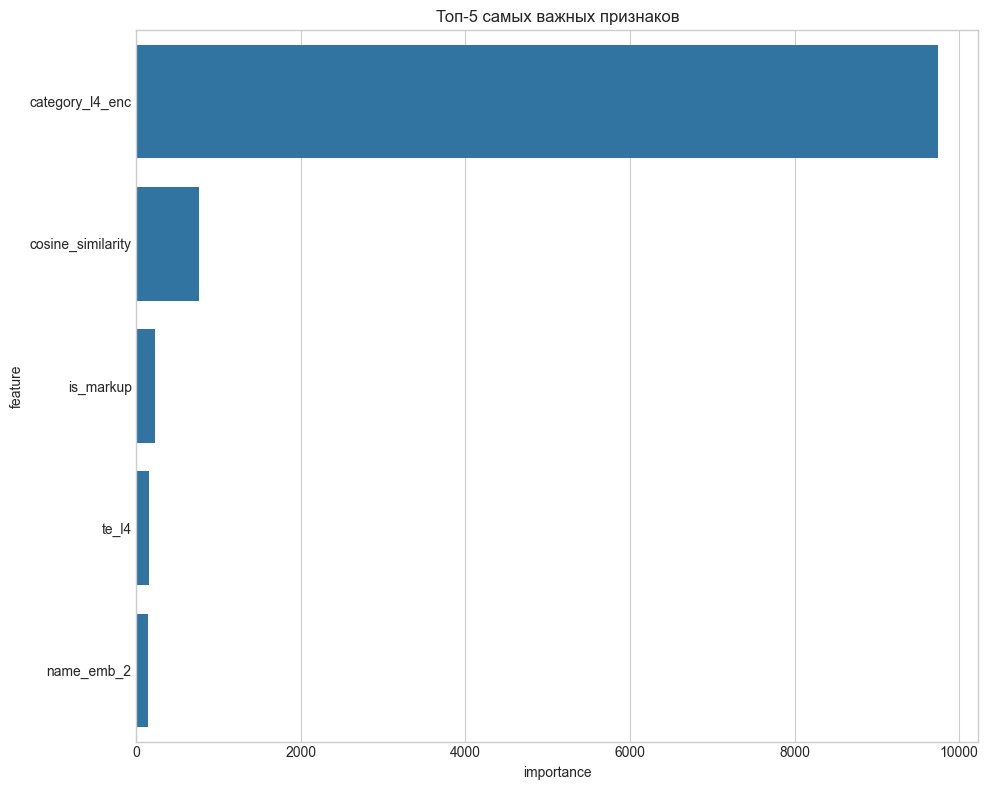


2. Анализ ошибок (примеры, на которых модель ошибается)...

Примеры самых уверенных ЛОЖНОПОЛОЖИТЕЛЬНЫХ срабатываний (True=0, Pred > 0.5)


,name,type,true_target,prediction
672000,"Аэрограф, немецкая Lufthansa HANSA Infinity126...",Аэрограф для творчества,0,0.999981
426882,Металлизированная добавка Диамант 100 Красное ...,Добавка для затирки,0,0.999972
469451,Акриловая лента для дизайна ногтей-1 упаковка ...,Подставка для маникюра,0,0.999949
44734,Инкубатор для понер акриловый с принтом,Муравьиная ферма,0,0.999948
470566,"Сменные принадлежности для прополочной машины,...",Полольник,0,0.999944



Примеры самых уверенных ЛОЖНООТРИЦАТЕЛЬНЫХ срабатываний (True=1, Pred < 0.5)


,name,type,true_target,prediction
563476,Конвертер сигнала A D и D A для Matrix A8 SVS ...,"Бумага для консервации, хранения",1,0.000059
469114,Угги Детские зимние ботинки,Услуги по поиску работы,1,0.000062
632991,Экологичное мыло для стирки с запахом мяты,Световая башня,1,0.000070
189811,"Набор ковриков для ванны и туалета Доляна ""Кам...",Услуги по поиску работы,1,0.000088
198620,"Картина модульная на холсте Модулка ""Танец с ш...",Курс по охране окружающей среды,1,0.000093



3. Анализ калибровки модели (насколько можно доверять вероятностям)...


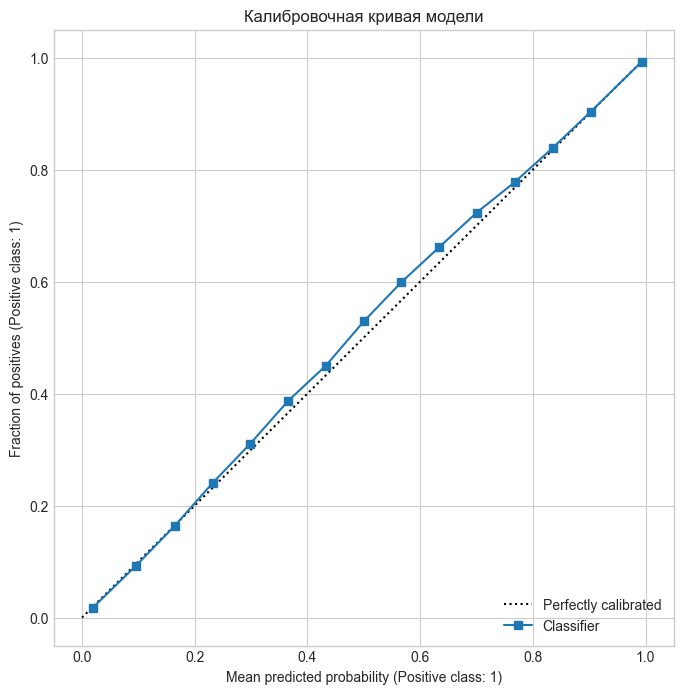


4. Анализ качества в разрезе категорий L2...


Анализ по категориям: 100%|██████████| 29/29 [00:01<00:00, 27.53it/s]

                                   ROC_AUC
Ювелирные изделия                 0.998857
Книги                             0.996986
Мебель                            0.996647
Кино, музыка, видеоигры, софт     0.996429
Товары для взрослых               0.992404
Галантерея и аксессуары           0.992314
Дом и сад                         0.992093
Автотовары                        0.991954
Обувь                             0.988497
Одежда                            0.987045
Строительство и ремонт            0.984416
Товары для животных               0.978525
Электроника                       0.974840
Канцелярские товары               0.973220
Детские товары                    0.971857
Хобби и творчество                0.969075
Бытовая техника                   0.965455
Продукты питания                  0.963102
Красота и гигиена                 0.957764
Аптека                            0.956929
Фермерское хозяйство              0.955783
Спорт и отдых                     0.955704
Автомототех

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, precision_recall_curve, auc
from sklearn.calibration import calibration_curve, CalibrationDisplay

# ЧАСТЬ 4: ГЛУБОКИЙ АНАЛИЗ РЕЗУЛЬТАТОВ

print("\nЧАСТЬ 4: ГЛУБОКИЙ АНАЛИЗ РЕЗУЛЬТАТОВ")

# Анализируем важность признаков 
print("\n1. Обучаем финальную модель для анализа важности признаков...")
# Для чистоты анализа обучим одну модель на всех данных
final_model = lgb.LGBMClassifier(objective='binary', metric='auc', random_state=42, n_estimators=1000)
cat_feature_names = ['category_l2_enc', 'category_l4_enc', 'is_markup']
final_model.fit(X, y, categorical_feature=cat_feature_names)

# Собираем важность признаков в DataFrame
feature_importance_df = pd.DataFrame({
    'feature': final_model.feature_name_,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False)

# Визуализируем топ-5 признаков
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(5))
plt.title('Топ-5 самых важных признаков')
plt.tight_layout()
plt.show()

# Анализируем ошибки модели 
print("\n2. Анализ ошибок (примеры, на которых модель ошибается)...")
df_results = df.copy()
df_results['prediction'] = oof_preds
df_results['true_target'] = y

# Находим самые уверенные ошибки
false_positives = df_results[(df_results['true_target'] == 0) & (df_results['prediction'] > 0.5)]
false_negatives = df_results[(df_results['true_target'] == 1) & (df_results['prediction'] < 0.5)]

print("\nПримеры самых уверенных ЛОЖНОПОЛОЖИТЕЛЬНЫХ срабатываний (True=0, Pred > 0.5)")
display(false_positives.sort_values('prediction', ascending=False).head(5)[['name', 'type', 'true_target', 'prediction']])

print("\nПримеры самых уверенных ЛОЖНООТРИЦАТЕЛЬНЫХ срабатываний (True=1, Pred < 0.5)")
display(false_negatives.sort_values('prediction', ascending=True).head(5)[['name', 'type', 'true_target', 'prediction']])


# Выводим калибровочную кривую
print("\n3. Анализ калибровки модели (насколько можно доверять вероятностям)...")
plt.figure(figsize=(8, 8))
ax = plt.gca()
CalibrationDisplay.from_predictions(y, oof_preds, n_bins=15, ax=ax)
plt.title('Калибровочная кривая модели')
plt.show()


# Анализируем качество по категориям L2
print("\n4. Анализ качества в разрезе категорий L2...")
category_auc = {}
for category in tqdm(df['category_l2'].unique(), desc="Анализ по категориям"):
    mask = df['category_l2'] == category
    if df[mask]['target'].nunique() > 1: # Убедимся, что есть оба класса
        score = roc_auc_score(df[mask]['target'], oof_preds[mask])
        category_auc[category] = score

auc_by_cat_df = pd.DataFrame.from_dict(category_auc, orient='index', columns=['ROC_AUC'])
print(auc_by_cat_df.sort_values('ROC_AUC', ascending=False).to_string())

##### ГЛУБОКИЙ АНАЛИЗ РЕЗУЛЬТАТОВ
1. **Топ-5 самых важных признаков**. Модель принимает решения, основываясь в первую очередь на конкретной подкатегории товара и смысловой близости текстов.

2. **Анализ ошибок** показал проблемы в качестве исходной разметки. Наша модель не просто выучила данные "как есть", а уловила общие семантические закономерности и теперь может выступать в роли "санитара данных", т.е. она не только может решать основную задачу, но и может быть использована для улучшения качества всего каталога товаров.

3. **Анализ калибровки модели**. На графике есть две линии. Идеальная — это диагональная пунктирная линия. Вторая, синяя сплошная линия, — это кривая нашей модели. Как видно, она у нас стремиться к идеалу и очень к ней близка

4. **Анализ качества в разрезе категорий L2**. Здесь мы видим табильность на большинстве категорий. Модель показывает высокое качество (ROC-AUC в районе 0.98-0.99) почти на всех ключевых товарных категориях, таких как "Ювелирные изделия", "Мебель", "Книги" и т.д.

In [22]:
# ЧАСТЬ 5: ДОПОЛНИТЕЛЬНЫЙ АНАЛИЗ КАЧЕСТВА

print("\n--- ЧАСТЬ 5: ДОПОЛНИТЕЛЬНЫЙ АНАЛИЗ КАЧЕСТВА ---")

# Анализируем качество по признаку is_markup
print("\nАнализ качества в разрезе is_markup (стандартный/нестандартный товар)...")
markup_auc = {}
for is_markup_value in [True, False]:
    mask = df['is_markup'] == is_markup_value
    score = roc_auc_score(df[mask]['target'], oof_preds[mask])
    markup_auc[f'is_markup={is_markup_value}'] = score

print(pd.Series(markup_auc))

# Анализируем качество по самым частым типам (type) 
print("\nАнализ качества в разрезе 20 самых популярных ТИПОВ...")
type_auc = {}
top_20_types = df['type'].value_counts().head(20).index

for t in tqdm(top_20_types, desc="Анализ по типам"):
    mask = df['type'] == t
    # Проверяем, что в данной группе есть оба класса (0 и 1)
    if df[mask]['target'].nunique() > 1:
        score = roc_auc_score(df[mask]['target'], oof_preds[mask])
        type_auc[t] = score

type_auc_df = pd.DataFrame.from_dict(type_auc, orient='index', columns=['ROC_AUC'])
print(type_auc_df.sort_values('ROC_AUC', ascending=False).to_string())


--- ЧАСТЬ 5: ДОПОЛНИТЕЛЬНЫЙ АНАЛИЗ КАЧЕСТВА ---

Анализ качества в разрезе is_markup (стандартный/нестандартный товар)...
is_markup=True     0.935174
is_markup=False    0.982328
dtype: float64

Анализ качества в разрезе 20 самых популярных ТИПОВ...


Анализ по типам: 100%|██████████| 20/20 [00:00<00:00, 39.43it/s]

                                                       ROC_AUC
Картина                                               0.999962
Фотообои                                              0.999933
Фильтр воздушный                                      0.999933
Матрас                                                0.999921
Фильтр салонный                                       0.999846
Комплект постельного белья                            0.999845
Колодки тормозные                                     0.999806
Постер                                                0.999796
Фильтр масляный                                       0.999659
Рассада                                               0.999314
Часы наручные                                         0.999188
Саженец                                               0.999022
Печатная книга: Молодежная художественная литература  0.998854
Кружка                                                0.997323
Кроссовки                                             0

#### Анализ качества в разрезе is_markup

Здесь мы наблюдаем снижение качества на "нестандартных" товарах (is_markup=True). Качество с меткой is_markup=True (ROC-AUC 0.935) заметно ниже, чем для стандартных товаров (ROC-AUC 0.982). Это ожидаемо, но подтверждает, что с уникальными, нестандартными товарами наша модель справляется хуже. 

В дальнейшем при тестировании товаров, помеченных как нестандартные, можно понизить порог уверенности для рекомендации или добавить дополнительный шаг ручной проверки.

#### Анализ качества в разрезе 20 самых популярных тиаов

Единственная серьезная уязвимость модели - проблема с "нематериальными" типами (услуги, курсы). Это главная и единственная серьезная уязвимость модели.  

Анализ по типам показал, что для нематериальных товаров, таких как:

- Проектирование (ROC-AUC: 0.58)

- Курс по охране окружающей среды (ROC-AUC: 0.57)

- Проживание в пансионате (ROC-AUC: 0.54)

- Услуги по поиску работы (ROC-AUC: 0.42)  
качество предсказаний находится на уровне случайного угадывания.  

Модель, обученная на физических товарах, не понимает семантику услуг.


--- ЧАСТЬ 6: ПРОВЕРКА НА ПЕРЕОБУЧЕНИЕ (КРИВАЯ ОБУЧЕНИЯ) ---
[LightGBM] [Info] Number of positive: 25918, number of negative: 21767
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 393211
[LightGBM] [Info] Number of data points in the train set: 47685, number of used features: 1549
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4080 SUPER, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 1547 dense feature groups (70.40 MB) transferred to GPU in 0.018928 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.543525 -> initscore=0.174543
[LightGBM] [Info] Start training from score 0.174543
[LightGBM] [Info] Number of positive: 76499, number of negative: 78478
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 393280
[LightGBM] [Info] Number of data points in th

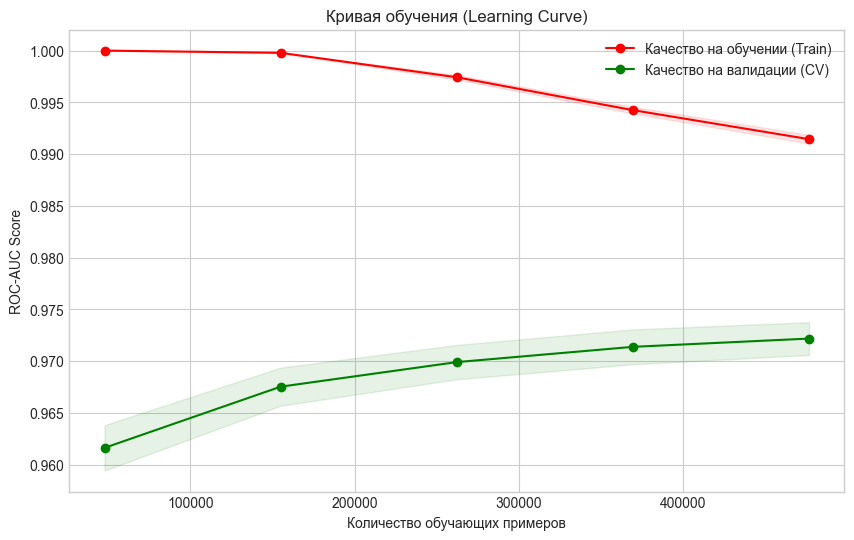

In [23]:
# ЧАСТЬ 6: ПРОВЕРКА НА ПЕРЕОБУЧЕНИЕ (КРИВАЯ ОБУЧЕНИЯ)

from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

print("\n--- ЧАСТЬ 6: ПРОВЕРКА НА ПЕРЕОБУЧЕНИЕ (КРИВАЯ ОБУЧЕНИЯ) ---")

# 1. Инициализируем модель с теми же параметрами
# Мы используем новую копию, так как функция learning_curve сама будет ее обучать
final_model_for_curve = lgb.LGBMClassifier(
    objective='binary',
    metric='auc',
    random_state=42,
    n_estimators=1000,
    device='gpu' 
)

# 2. Определяем размеры выборок для построения кривой
train_sizes_abs, train_scores, test_scores = learning_curve(
    estimator=final_model_for_curve,
    X=X,
    y=y,
    train_sizes=np.linspace(0.1, 1.0, 5),
    cv=3,
    scoring='roc_auc',
    n_jobs=1,  # <--- ИЗМЕНЕНИЕ ЗДЕСЬ. Выполняем в одном потоке
    random_state=42
)

# 3. Считаем средние и стандартные отклонения для графиков
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# 4. Строим график
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(10, 6))
plt.title("Кривая обучения (Learning Curve)")
plt.xlabel("Количество обучающих примеров")
plt.ylabel("ROC-AUC Score")

# Рисуем кривую для обучающей выборки
plt.plot(train_sizes_abs, train_scores_mean, 'o-', color="r", label="Качество на обучении (Train)")
plt.fill_between(train_sizes_abs, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")

# Рисуем кривую для валидационной выборки
plt.plot(train_sizes_abs, test_scores_mean, 'o-', color="g", label="Качество на валидации (CV)")
plt.fill_between(train_sizes_abs, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")

plt.legend(loc="best")
plt.grid(True)
plt.show()

#### Выводы по кривой обучения

График подтверждает, что модель **хорошо обучена, робастна** и не страдает от серьезного переобучения.

* **Высокое качество на новых данных:** Самый важный показатель — качество на валидации (зеленая линия) — достиг отличного значения **ROC-AUC `0.973`**. Это говорит о высокой обобщающей способности модели.

* **Минимальное переобучение:** Небольшой и ожидаемый разрыв с качеством на обучении (красная линия, **`0.992`**) является нормой для мощных моделей и указывает на приемлемый уровень переобучения.

* **Итог:** Кривая обучения — это наглядное доказательство того, что модель успешно выучила общие закономерности, а не просто "запомнила" обучающие данные.